# Clustering by Wine Color

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
<pre>
Dua, D. and Karra Taniskidou, E. (2017). 
UCI Machine Learning Repository [http://archive.ics.uci.edu/ml/index.php]. 
Irvine, CA: University of California, School of Information and Computer Science.
</pre>

<pre>
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
</pre>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

red_wine = pd.read_csv('winequality-red.csv')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

## EDA

In [ ]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
def plot_quality_scores(df, kind):
    ax = df.quality.value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    ax.axes.invert_yaxis()
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    return ax
    

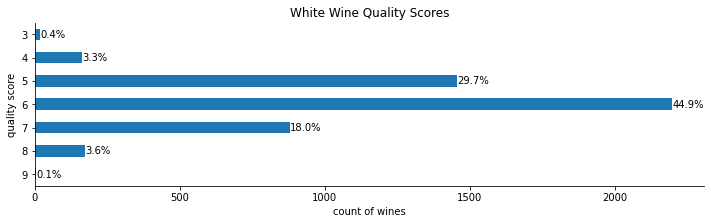

In [ ]:
plot_quality_scores(white_wine, 'white')
plt.show()

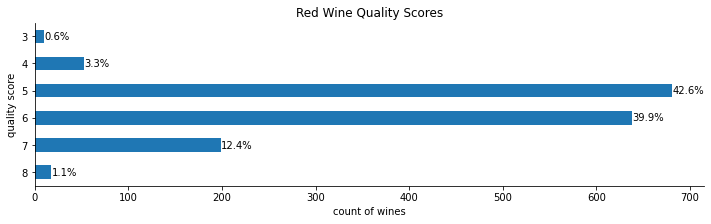

In [ ]:
plot_quality_scores(red_wine, 'red')
plt.show()

Combining the wine data:

In [ ]:
wine = pd.concat([white_wine.assign(kind='white'), red_wine.assign(kind='red')]).reset_index(drop=True)
wine.sample(5, random_state=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kind
5746,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5,red
2529,6.6,0.42,0.13,12.8,0.044,26.0,158.0,0.99772,3.24,0.47,9.0,5,white
5029,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,red
5142,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red
1551,6.6,0.19,0.99,1.2,0.122,45.0,129.0,0.99360,3.09,0.31,8.7,6,white


EDA on the wine data as a whole:

In [ ]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  kind                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [ ]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [ ]:
wine.describe(include='object')

,kind
count,6497
unique,2
top,white
freq,4898


In [ ]:
wine.kind.value_counts()

white    4898
red      1599
Name: kind, dtype: int64

## Clustering to Separate Red and White Wines

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
y = wine.kind
X = wine.drop(columns=['quality', 'kind'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

kmeans_pipeline = Pipeline([('scale', StandardScaler()),
                            ('kmeans', KMeans(n_clusters=2, random_state=0))])\
                            .fit(X_train)

### Measure the agreement between predicted wine type and actual

In [ ]:
pd.Series(kmeans_pipeline.predict(X_test)).value_counts()

1    1211
0     414
dtype: int64

In [ ]:
y_test.value_counts()

white    1225
red       400
Name: kind, dtype: int64

#### Fowlkes Mallows Index
Values are in the range [0, 1] where 1 is perfect agreement:
$$ FMI = \frac{TP}{\sqrt{(TP + FP)\times(TP + FN)}} $$
where
- TP = points that are in the same cluster in the true labels are predicted to be in the same cluster
- FP = points that are in the same cluster in the true labels but are not predicted to be in the same cluster
- FN = points that are not in the same cluster in the true labels but are predicted to be in the same cluster

In [ ]:
from sklearn.metrics import fowlkes_mallows_score
# we need to make y_test binary, but which label red becomes doesn't matter for the result
fowlkes_mallows_score(np.where(y_test == 'red', 0, 1), kmeans_pipeline.predict(X_test))

0.9824673716471775

### Finding the Centroids

In [ ]:
 pd.DataFrame(kmeans_pipeline.named_steps['kmeans'].cluster_centers_, columns=X_train.columns).T

,0,1
fixed acidity,0.812249,-0.275812
volatile acidity,1.177196,-0.399735
citric acid,-0.367437,0.124769
residual sugar,-0.629236,0.213667
chlorides,0.940155,-0.319244
free sulfur dioxide,-0.843805,0.286527
total sulfur dioxide,-1.191533,0.404604
density,0.662905,-0.225100
pH,0.572273,-0.194324
sulphates,0.848551,-0.288139
